In [ ]:
!pip install mlflow --quiet

In [ ]:
!pip install catboost

In [ ]:
! pip install optuna

In [33]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

import optuna

In [24]:
import lightgbm as lgb

In [4]:
df_train = pd.read_csv('/kaggle/input/final-data/df_sales_train_all_final.csv')
df_test = pd.read_csv('/kaggle/input/final-data/df_sales_test_all_final.csv')

In [5]:
df_train.shape

(4007419, 28)

In [6]:
df_train = df_train.sort_values(by=['warehouse', 'name', 'date'])

# Handle Missing Values

In [8]:
df_train.dropna(subset=["sales"], inplace=True)
df_train.isna().sum()

unique_id                 0
date                      0
warehouse                 0
total_orders              0
sales                     0
sell_price_main           0
availability              0
type_0_discount           0
type_1_discount           0
type_2_discount           0
type_3_discount           0
type_4_discount           0
type_5_discount           0
type_6_discount           0
country                   0
holiday                   0
shops_closed              0
winter_school_holidays    0
school_holidays           0
school_holiday_custom     0
holiday_next_3_days       0
holiday_next_1_days       0
name                      0
L1_category_name_en       0
L2_category_name_en       0
L3_category_name_en       0
L4_category_name_en       0
weight                    0
dtype: int64

# Feature engineering

In [9]:
# Function to Add Time-Based Features
def add_time_features(df):
    """
    Adds time-based features to a DataFrame with a 'date' column.

    Args:
    df (pd.DataFrame): Input DataFrame containing a 'date' column.

    Returns:
    pd.DataFrame: DataFrame with added time-based features.
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])  # Ensure date format

    # Basic date features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day_of_week"] = df["date"].dt.dayofweek
    df["day_of_year"] = df["date"].dt.dayofyear
    df["week_of_year"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    df["quarter"] = df["date"].dt.quarter

    # Cyclical encoding for time-based features
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12.0)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12.0)
    df["day_of_week_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7.0)
    df["day_of_week_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7.0)
    df["day_of_year_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365.0)
    df["day_of_year_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365.0)
    df["week_of_year_sin"] = np.sin(2 * np.pi * df["week_of_year"] / 52.0)
    df["week_of_year_cos"] = np.cos(2 * np.pi * df["week_of_year"] / 52.0)

    # Additional time cycles
    df["half_year_sin"] = np.sin(2 * np.pi * df["month"] / 6)
    df["half_year_cos"] = np.cos(2 * np.pi * df["month"] / 6)
    df["two_year_sin"] = np.sin(2 * np.pi * df["year"] / 2)
    df["two_year_cos"] = np.cos(2 * np.pi * df["year"] / 2)

    df["max_discount"] = df[
    ["type_0_discount", "type_1_discount", "type_2_discount", "type_3_discount", "type_4_discount", "type_5_discount", "type_6_discount"]
    ].max(axis=1)
    return df


In [92]:
# Function to Add Shifting and Rolling Features
def add_feature_shifts(df):
    """
    Adds shifting and rolling features for sales and price data.

    Args:
    df (pd.DataFrame): Input DataFrame containing 'sales' and 'sell_price_main' columns.

    Returns:
    pd.DataFrame: DataFrame with added lag, rolling, and additional features.
    """
    df = df.copy()

    # Lag Features
    df['sales_lag_1'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].shift(1)
    df['sales_lag_7'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].shift(7)
    df['sales_lag_30'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].shift(30)

    # Rolling Features
    df['sales_rolling_mean_7'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean()).shift(1)
    df['sales_rolling_std_7'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].transform(lambda x: x.rolling(7, min_periods=1).std()).shift(1)
    df['sales_rolling_mean_14'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].transform(lambda x: x.rolling(14, min_periods=1).mean()).shift(1)
    df['sales_rolling_std_14'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].transform(lambda x: x.rolling(14, min_periods=1).std()).shift(1)
    df['sales_rolling_mean_30'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].transform(lambda x: x.rolling(30, min_periods=1).mean()).shift(1)
    df['sales_rolling_std_30'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].transform(lambda x: x.rolling(30, min_periods=1).std()).shift(1)

    # Exponentially Weighted Mean
    df['sales_exp_weighted_3'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].transform(lambda x: x.ewm(span=3, adjust=False).mean()).shift(1)
    df['sales_exp_weighted_7'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].transform(lambda x: x.ewm(span=7, adjust=False).mean()).shift(1)
    df['sales_exp_weighted_14'] = df.groupby(['warehouse', 'name'], observed=True)['sales'].transform(lambda x: x.ewm(span=14, adjust=False).mean()).shift(1)

    # Week-over-Week Change
    df['sales_wow_change'] = (df['sales'] / df.groupby(['warehouse', 'name'], observed=True)['sales'].shift(7) - 1).shift(1)

    # Price Elasticity
    df['price_change_1'] = df.groupby(['warehouse', 'name'], observed=True)['sell_price_main'].pct_change()
    df['price_change_7'] = df.groupby(['warehouse', 'name'], observed=True)['sell_price_main'].pct_change(periods=7)

    # Trend Feature
    df['sales_trend_7_14'] = df['sales_rolling_mean_7'] - df['sales_rolling_mean_14']
    df['sales_trend_14_30'] = df['sales_rolling_mean_14'] - df['sales_rolling_mean_30']

    # Shift the trend features
    df['sales_trend_7_14'] = df['sales_trend_7_14'].shift(1)
    df['sales_trend_14_30'] = df['sales_trend_14_30'].shift(1)

    return df

In [11]:
train = add_time_features(df_train)
train = add_feature_shifts(train)

In [19]:
categorical_features = [
    'warehouse',
    'holiday',
    'shops_closed',
    'school_holiday_custom',
    'holiday_next_1_days',
    'name'
]

numerical_features = [
    'total_orders',
    'sell_price_main',
   # 'availability',
   # 'type_0_discount',
   # 'type_1_discount',
   # 'type_2_discount',
   # 'type_3_discount',
   # 'type_4_discount',
   #'type_5_discount',
   # 'type_6_discount',
    'max_discount',
    'year',
    'month',
    'day_of_week',
    'day_of_year',
    'week_of_year',
    'is_weekend',
    'quarter',
    'month_sin',
    'month_cos',
    'day_of_week_sin',
    'day_of_week_cos',
    'day_of_year_sin',
    'day_of_year_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'half_year_sin',
    'half_year_cos',
    'two_year_sin',
    'two_year_cos',
    #'three_year_sin',
    #'three_year_cos',
    #'four_year_sin',
    #'four_year_cos',
    'sales_lag_1',
    'sales_lag_7',
    'sales_lag_30',
    'sales_rolling_mean_7',
    'sales_rolling_std_7',
    'sales_rolling_mean_14',
    'sales_rolling_std_14',
    'sales_rolling_mean_30',
    'sales_rolling_std_30',
    'sales_exp_weighted_3',
    'sales_exp_weighted_7',
    'sales_exp_weighted_14',
    'sales_wow_change',
    'price_change_1',
    'price_change_7',
    'sales_trend_7_14',
    'sales_trend_14_30'
]

In [20]:
def weighted_mae(y_true, y_pred, weights):
    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)

In [21]:
############
unique_dates = sorted(train['date'].unique())
split_date = unique_dates[int(0.82 * len(unique_dates))]
print(split_date)
train_set = train[train['date'] <= split_date]
test_set = train[train['date'] > split_date]
print(len(train_set)/len(train))

#split_idx = int(len(train) * 0.8)  # 80% train, 20% test
features = numerical_features + categorical_features
target = "sales"

#train_sorted = train.sort_values(by="date")  # Ensure sorting by time
#train_set = train_sorted.iloc[:split_idx]
#test_set = train_sorted.iloc[split_idx:]

X_train, y_train, w_train = train_set[features], train_set[target], train_set["weight"]
X_test, y_test, w_test = test_set[features], test_set[target], test_set["weight"]

train_pool = Pool(X_train, label=y_train, cat_features=[features.index(f) for f in categorical_features])
test_pool = Pool(X_test, label=y_test, cat_features=[features.index(f) for f in categorical_features])

2023-09-24 00:00:00
0.7828901121359736


In [ ]:
# for LGBM
for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")
train_data = lgb.Dataset(X_train, label=y_train, weight=w_train, 
                         categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, weight=w_test, 
                        categorical_feature=categorical_features, 
                        reference=train_data)

In [29]:
# Define parameters
params = {
    "objective": "mae",
    "metric": "mae",
    "learning_rate": 0.1,
    "num_leaves": 31,
    "max_depth": 6,
    "verbose": -1
}

# Train LGBM model
model = lgb.train(params, train_data, valid_sets=[test_data])

# Predict
preds = model.predict(X_test)

# Calculate WMAE
wmae = weighted_mae(y_test, preds, w_test)
print(f"LGBM Test WMAE: {wmae}")

# Save model
model.save_model("lgbm_model.txt")

LGBM Test WMAE: 18.348283214199736


In [30]:
import joblib

# Save model
joblib.dump(model, "lgbm_model_1.pkl")
print("Model saved successfully!")

Model saved successfully!


In [22]:
#model = CatBoostRegressor(
#        iterations=1500,
#        depth=7,
#        learning_rate=0.3,
#        loss_function='MAE',
#        l2_leaf_reg=5.33,  
#        random_strength=9.087,  
#        bagging_temperature=0.53,
#        border_count=236,
#        verbose=100
#    )
#
## Train the model with early stopping
#model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)
#
## Make predictions
#preds = model.predict(X_test)
#
## Compute WMAE
#wmae = weighted_mae(y_test, preds, w_test)
#
## Print evaluation metric
#print(f"Test WMAE: {wmae}")

0:	learn: 76.3579863	test: 75.3224424	best: 75.3224424 (0)	total: 1.43s	remaining: 35m 50s
100:	learn: 22.1869725	test: 40.2634717	best: 29.3084309 (53)	total: 2m 17s	remaining: 31m 44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 29.30843093
bestIteration = 53

Shrink model to first 54 iterations.
Test WMAE: 19.23347940956631


In [23]:
#model.save_model("catboost_model_v2.cbm")
#import pickle
#with open("catboost_model_v2.pkl", "wb") as f:
#    pickle.dump(model, f)
#print("✅ Model saved successfully!")

✅ Model saved successfully!


In [38]:
# Define split points
unique_dates = sorted(train['date'].unique())
train_cutoff = unique_dates[int(0.80 * len(unique_dates))]  # 80% Train
val_cutoff = unique_dates[int(0.90 * len(unique_dates))]  # 10% Validation

print(f"Train cutoff: {train_cutoff}, Validation cutoff: {val_cutoff}")

# Create Train, Validation, and Test Sets
train_set = train[train['date'] <= train_cutoff]
val_set = train[(train['date'] > train_cutoff) & (train['date'] <= val_cutoff)]
test_set = train[train['date'] > val_cutoff]

print(f"Train: {len(train_set)/len(train):.2%}, Validation: {len(val_set)/len(train):.2%}, Test: {len(test_set)/len(train):.2%}")

# Define Features & Target
features = numerical_features + categorical_features
target = "sales"

# Extract Inputs and Labels
X_train, y_train, w_train = train_set[features], train_set[target], train_set["weight"]
X_val, y_val, w_val = val_set[features], val_set[target], val_set["weight"]
X_test, y_test, w_test = test_set[features], test_set[target], test_set["weight"]

for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")
    X_test[col] = X_test[col].astype("category")

# Create CatBoost Pools
#train_pool = Pool(X_train, label=y_train, cat_features=[features.index(f) for f in categorical_features])
#val_pool = Pool(X_val, label=y_val, cat_features=[features.index(f) for f in categorical_features])
#test_pool = Pool(X_test, label=y_test, cat_features=[features.index(f) for f in categorical_features])

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=train_data)


Train cutoff: 2023-08-27 00:00:00, Validation cutoff: 2024-01-14 00:00:00
Train: 75.87%, Validation: 12.11%, Test: 12.02%


<ipython-input-38-b07be0d6993e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype("category")
<ipython-input-38-b07be0d6993e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col] = X_val[col].astype("category")
<ipython-input-38-b07be0d6993e>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [39]:
#GPU_PARAMS = {
#    "task_type": "GPU",  # Use GPU for training
#    "devices": "0"       # Use the first GPU (Change if multiple GPUs are available)
#}

In [40]:
# Define WMAE function
#def weighted_mae(y_true, y_pred, weights):
#    return np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
#
## Define objective function
#def objective(trial):
#    params = {
#        "iterations": trial.suggest_int("iterations", 200, 2000),  # More iterations for better convergence
#        "depth": trial.suggest_int("depth", 4, 10),
#        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
#        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
#        "random_strength": trial.suggest_float("random_strength", 1, 10),
#        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
#        "border_count": trial.suggest_int("border_count", 32, 255),
#        "loss_function": "Quantile:alpha=0.5",
#        "verbose": 0,
#        **GPU_PARAMS 
#    }
#
#    # Train CatBoost model with GPU
#    model = CatBoostRegressor(**params)
#    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=0)
#
#    # Predict on validation set
#    preds = model.predict(X_val)
#
#    # Compute WMAE
#    wmae_score = weighted_mae(y_val, preds, w_val)

#    return wmae_score

#study = optuna.create_study(direction="minimize")  # Minimize WMAE
#study.optimize(objective, n_trials=50)
#
## Get best hyperparameters
#best_params = study.best_params
#print("Best Hyperparameters:", best_params)
#
## Train final model with best parameters (Using GPU)
#final_model = CatBoostRegressor(**best_params, **GPU_PARAMS)
#final_model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=50, verbose=100)
#
## Predictions on Test Set
#final_preds = final_model.predict(X_test)
#final_wmae = weighted_mae(y_test, final_preds, w_test)
#
#print(f"Final Model WMAE on Test Set: {final_wmae:.4f}")

#final_model.save_model("catboost_model.cbm")
#import pickle
#with open("catboost_model.pkl", "wb") as f:
#    pickle.dump(final_model, f)
#print("✅ Model saved successfully!")

In [46]:
def objective(trial):
    params = {
        "objective": "regression",
        "metric": "mae",
        "boosting_type": "gbdt",
        "device": "cpu",  # Enable GPU training
        "gpu_platform_id": 0,
        "gpu_device_id": 0,
        "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.2, log=True), 
        "num_leaves": trial.suggest_int("num_leaves", 300, 550),
        "max_depth": trial.suggest_int("max_depth", 6, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 800, 15000),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0), 
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0), 
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 4, 7, log=True),  
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 2, log=True),  # Updated

        "verbose": -1  # Silence the output
    }

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    model = lgb.train(params, lgb_train, valid_sets=[lgb_valid])
    preds = model.predict(X_val)

    wmae_score = weighted_mae(y_val, preds, w_val)
    return wmae_score

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2025-02-14 17:00:56,281] A new study created in memory with name: no-name-1df7dae6-7a01-4413-b9a5-40a8d7bc5348
[I 2025-02-14 17:01:34,474] Trial 0 finished with value: 18.513679815283606 and parameters: {'learning_rate': 0.11205612824045444, 'num_leaves': 414, 'max_depth': 11, 'min_data_in_leaf': 13823, 'feature_fraction': 0.7809742079982157, 'bagging_fraction': 0.9363958187237116, 'bagging_freq': 9, 'lambda_l1': 6.078674984133083, 'lambda_l2': 1.348812421842848e-07}. Best is trial 0 with value: 18.513679815283606.
[I 2025-02-14 17:01:56,312] Trial 1 finished with value: 19.951891657079244 and parameters: {'learning_rate': 0.15180522638686061, 'num_leaves': 485, 'max_depth': 6, 'min_data_in_leaf': 10225, 'feature_fraction': 0.7117540667260522, 'bagging_fraction': 0.5806146542799595, 'bagging_freq': 5, 'lambda_l1': 4.5463803942036085, 'lambda_l2': 0.0013277581395053232}. Best is trial 0 with value: 18.513679815283606.
[I 2025-02-14 17:02:33,165] Trial 2 finished with value: 18.003533

In [50]:
params = {
    "objective": "mae",
    "metric": "mae",
    'learning_rate': 0.16221970170547098, 
    'num_leaves': 301, 
    'max_depth': 10, 
    'min_data_in_leaf': 4905, 
    'feature_fraction': 0.5796492573260097, 
    'bagging_fraction': 0.5332025938620939, 
    'bagging_freq': 6, 
    'lambda_l1': 4.917437401706084, 
    'lambda_l2': 2.267808660557631e-06
    "verbose": -1
}

for col in categorical_features:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")
train_data = lgb.Dataset(X_train, label=y_train, weight=w_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, weight=w_test, categorical_feature=categorical_features, reference=train_data)

# Train LGBM model
model_best = lgb.train(params, train_data, valid_sets=[test_data])
preds = model.predict(X_test)
wmae = weighted_mae(y_test, preds, w_test)
print(f"LGBM Test WMAE: {wmae}")
model.save_model("lgbm_model_best_optuna.txt")

<ipython-input-50-bfadaff10ae6>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col] = X_train[col].astype("category")
<ipython-input-50-bfadaff10ae6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype("category")


LGBM Test WMAE: 18.706632377088138


<ipython-input-54-b50f586af1b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['prediction'] = preds
<ipython-input-54-b50f586af1b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['true'] = y_test
<ipython-input-54-b50f586af1b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

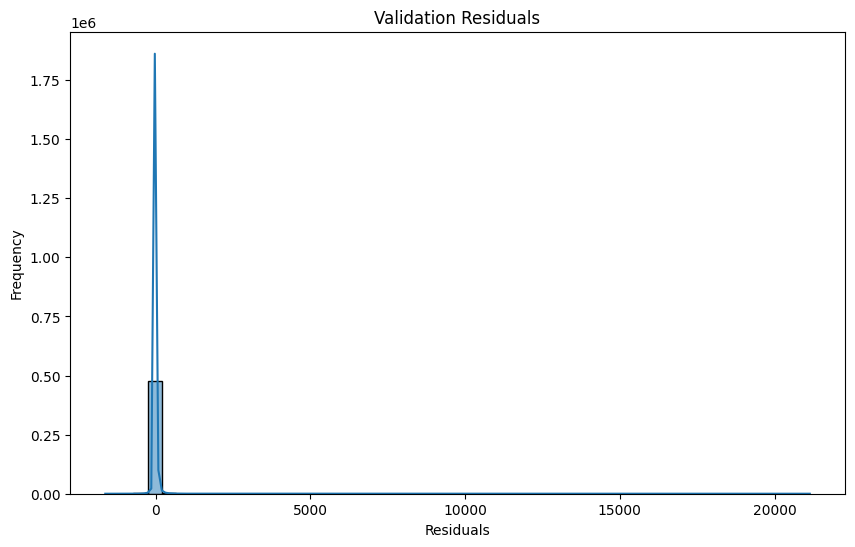

In [54]:
# X_test, y_test, w_test
X_test['prediction'] = preds
X_test['true'] = y_test
X_test['residual'] = X_test['true'] - X_test['prediction']

# Plot residuals distribution
plt.figure(figsize=(10, 6))
sns.histplot(X_test['residual'], bins=50, kde=True)
plt.title("Validation Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [57]:
df_res_day_of_week_warehouse = X_test.groupby(['warehouse', "day_of_week"])["residual"].mean().reset_index()
df_res_day_of_week_warehouse = df_res_day_of_week_warehouse.rename(columns={"residual": "residual_day_of_week_warehouse"})
df_res_day_of_week_warehouse.sort_values("residual_day_of_week_warehouse", ascending=False, inplace=True)
df_res_day_of_week_warehouse.to_csv("/kaggle/working/df_res_day_of_week.csv", index=False)
df_res_day_of_week_warehouse

<ipython-input-57-becc4a258fea>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_res_day_of_week_warehouse = X_test.groupby(['warehouse', "day_of_week"])["residual"].mean().reset_index()


,warehouse,day_of_week,residual_day_of_week_warehouse
4,Brno_1,4,50.280282
32,Prague_1,4,36.061368
0,Brno_1,0,35.048460
25,Munich_1,4,34.571139
3,Brno_1,3,33.273761
21,Munich_1,0,30.513443
1,Brno_1,1,29.197764
2,Brno_1,2,26.279868
5,Brno_1,5,24.021776
6,Brno_1,6,19.303760


In [58]:
df_res_unique_id = X_test.groupby("name")["residual"].mean().reset_index()
df_res_unique_id = df_res_unique_id.rename(columns={"residual": "residual_unique"})
df_res_unique_id.sort_values("residual_unique", ascending=False, inplace=True)
df_res_unique_id.to_csv("/kaggle/working/df_res_warehouse.csv", index=False)
df_res_unique_id.head()

<ipython-input-58-d4968b997419>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_res_unique_id = X_test.groupby("name")["residual"].mean().reset_index()


,name,residual_unique
1635,Roll_51,13087.425655
1641,Roll_57,3992.167179
761,Cucumber_10,533.366650
1291,Pastry_4,338.047628
1775,Strawberry_25,201.685854


In [59]:
# Group for warehouse
df_res_warehouse = X_test.groupby("warehouse")["residual"].mean().reset_index()
df_res_warehouse = df_res_warehouse.rename(columns={"residual": "residual_warehouse"})
df_res_warehouse.sort_values("residual_warehouse", ascending=False, inplace=True)
df_res_warehouse.to_csv("/kaggle/working/df_res_warehouse.csv", index=False)
df_res_warehouse.head()

<ipython-input-59-a1b611566611>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_res_warehouse = X_test.groupby("warehouse")["residual"].mean().reset_index()


,warehouse,residual_warehouse
0,Brno_1,31.121473
4,Prague_1,17.215069
5,Prague_2,6.282194
6,Prague_3,4.949705
1,Budapest_1,4.250070


In [61]:
X_test = X_test.merge(df_res_unique_id, on="name", how="left")
X_test = X_test.merge(df_res_warehouse, on="warehouse", how="left")
X_test = X_test.merge(df_res_day_of_week_warehouse, on=['warehouse', "day_of_week"], how="left")

X_test["residual_unique"] = X_test["residual_unique"].fillna(0)
X_test["residual_warehouse"] = X_test["residual_warehouse"].fillna(0)
X_test["residual_day_of_week_warehouse"] = X_test["residual_day_of_week_warehouse"].fillna(0)

In [64]:
#residual_day_of_week_warehouse
def model_with_coefficients(alpha, beta, gamma, X_test, y_test, w_test):
    """
    Calculate predictions with given coefficients and compute WMAE.
    
    Args:
    alpha: Coefficient for the residual_unique feature.
    beta: Coefficient for the residual_warehouse feature.
    X_test: The test dataset with required features.
    
    Returns:
    WMAE: The weighted mean absolute error.
    """
    # Calculate the predictions based on the formula
    X_test["sales_hat_mod"] = X_test["prediction"] + \
                            alpha * X_test["residual_unique"] + \
                            beta * X_test["residual_warehouse"] + \
                            gamma * X_test["residual_day_of_week_warehouse"]
    
    y_pred = X_test["sales_hat_mod"]  # Predicted values
    
    weights = w_test
    
    return weighted_mae(y_test, y_pred, weights)

In [65]:
from scipy.optimize import minimize

# Define the objective function to minimize
def objective(params, X_test, y_test, w_test):
    alpha, beta, gamma = params
    return model_with_coefficients(alpha, beta, gamma, X_test, y_test, w_test)

# Initial guess for alpha and beta (e.g., [0.3, 0.1])
initial_guess = [0.3, 0.1, 0.1]

# Run optimization to minimize the WMAE
result = minimize(objective, initial_guess, args=(X_test, y_test, w_test), bounds=[(-1, 2), (-1, 2), (-1, 2)])

# Optimal coefficients
optimal_alpha, optimal_beta, optimal_gamma = result.x
print(f"Optimal alpha: {optimal_alpha}")
print(f"Optimal beta: {optimal_beta}")
print(f"Optimal beta: {optimal_gamma}")

Optimal alpha: -0.6812178744055449
Optimal beta: -0.24525504116894067
Optimal beta: -0.28469167626138187


In [138]:
X_test["sales_hat_new"] = X_test["prediction"] + optimal_alpha * X_test["residual_unique"] \
                            + optimal_beta * X_test["residual_warehouse"] \
                            + optimal_gamma * X_test["residual_day_of_week_warehouse"]
wmae = weighted_mae(y_test, X_test["sales_hat_new"], w_test)
print(f"WMAE on modified set (both): {wmae:.4f}")

WMAE on modified set (both): 13.7688


In [68]:
# For Catboost
#feature_importance = model.get_feature_importance()
#feature_names = model.feature_names_
#
## Convert to DataFrame for visualization
#importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
#importance_df = importance_df.sort_values(by='Importance', ascending=False)
#
## Plot feature importance
#plt.figure(figsize=(10,9))
#plt.barh(importance_df['Feature'], importance_df['Importance'])
#plt.xlabel('Importance')
#plt.ylabel('Feature')
#plt.title('Feature Importance (PredictionValuesChange)')
#plt.gca().invert_yaxis()
#plt.show()

# Iterative forecast

In [115]:
def iterative_forecast_with_history(model, train_df, test_df, features, categorical_features):
    test_df = test_df.copy()
    train_df["date"] = pd.to_datetime(train_df["date"])
    test_df["date"] = pd.to_datetime(test_df["date"])

    # Sort by warehouse, name, and date
    train_df = train_df.sort_values(by=['warehouse', 'name', 'date'])
    test_df = test_df.sort_values(by=['warehouse', 'name', 'date'])

    predictions = []
    result = []  # Store the result (id, date, prediction)

    # Get the last 30 rows for each group to initialize
    last_30_days = train_df.groupby(['warehouse', 'name']).tail(30)
    extended_test_df = pd.concat([last_30_days, test_df], ignore_index=True)
    extended_test_df['date'] = pd.to_datetime(extended_test_df['date'])

    # Iterate over the extended test set to make predictions
    for i in range(len(last_30_days), len(extended_test_df)):
        if (i - len(last_30_days)) % 500 == 0:
            print(f"Processing row {i - len(last_30_days)}")

        row = extended_test_df.iloc[i].copy()
        row['date'] = pd.to_datetime(row['date'])
        # Group-specific feature engineering (based on warehouse and name)
        group_data = extended_test_df[(extended_test_df['warehouse'] == row['warehouse']) &
                                      (extended_test_df['name'] == row['name']) &
                                      (extended_test_df['date'] <= row['date'])]
        group_data.reset_index(drop=True, inplace=True)
        row_df = pd.DataFrame([row])


        # Add general time features
        group_data = add_time_features(group_data)

        # Add shifting and rolling features
        #non_nan_idx = group_data[group_data['sales'].isna()].index[0]  # Get the index of non-NaN sales
        row_df = add_feature_shifts(group_data)
        last_row = row_df[row_df["date"] == row["date"]][:]
        #print(last_row)

        # Prepare the Pool for CatBoost prediction
        row_pool = Pool(
            last_row[features],
            cat_features=[features.index(f) for f in categorical_features]
        )

        # Make the prediction

        for col in categorical_features:
            last_row[col] = last_row[col].astype("category")
        pred = model.predict(last_row[features])[0]
        predictions.append(pred)

        # Store the result (id, date, prediction)
        result.append({
            "id": str(row['unique_id']) + '_' + row["date"].strftime('%Y-%m-%d'),
            'prediction': pred
        })

        # Update the extended_test_df with the prediction (optional, can be used for further analysis)
        extended_test_df.at[i, "sales"] = pred

    result_df = pd.DataFrame(result)
    return result_df

In [117]:
for col in categorical_features:
    df_train[col] = df_train[col].astype("category")
    df_test[col] = df_test[col].astype("category")

df_pred = iterative_forecast_with_history(model, df_train, df_test, features, categorical_features)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000
Processing row 10500
Processing row 11000
Processing row 11500
Processing row 12000
Processing row 12500
Processing row 13000
Processing row 13500
Processing row 14000
Processing row 14500
Processing row 15000
Processing row 15500
Processing row 16000
Processing row 16500
Processing row 17000
Processing row 17500
Processing row 18000
Processing row 18500
Processing row 19000
Processing row 19500
Processing row 20000
Processing row 20500
Processing row 21000
Processing row 21500
Processing row 22000
Processing row 22500
Processing row 23000
Processing row 23500
Processing row 2

In [118]:
df_pred

,id,prediction
0,46_2024-06-03,164.421793
1,46_2024-06-04,160.817894
2,46_2024-06-05,152.165258
3,46_2024-06-06,168.878902
4,46_2024-06-07,186.478952
...,...,...
47016,984_2024-06-12,27.256585
47017,984_2024-06-13,30.392562
47018,984_2024-06-14,32.277207
47019,984_2024-06-15,28.033795


In [119]:
df_test["date"] = pd.to_datetime(df_test['date'])
df_test["day_of_week"] = df_test["date"].dt.dayofweek
df_test = df_test.merge(df_res_unique_id, on="name", how="left")
df_test = df_test.merge(df_res_warehouse, on="warehouse", how="left")
df_test = df_test.merge(df_res_day_of_week_warehouse, on=['warehouse', "day_of_week"], how="left")

df_test["residual_unique"] = df_test["residual_unique"].fillna(0)
df_test["residual_warehouse"] = df_test["residual_warehouse"].fillna(0)
df_test["residual_day_of_week_warehouse"] = df_test["residual_day_of_week_warehouse"].fillna(0)

In [143]:
df_submission = df_test[['unique_id', 
                         'date', 
                         'residual_unique', 
                         'residual_warehouse', 
                         'residual_day_of_week_warehouse']
]

df_submission["id"] = (
    df_submission["unique_id"].astype(str) 
    + "_" 
    + df_submission["date"].astype(str)
)

df_sub = pd.merge(df_pred, df_submission, on="id")[
    ["id", "prediction", "residual_unique", 
     "residual_warehouse", "residual_day_of_week_warehouse"]
]

In [146]:
df_sub['sales_hat'] = df_sub["prediction"] - optimal_alpha * df_sub["residual_unique"] \
                            - optimal_beta * df_sub["residual_warehouse"] \
                            - optimal_gamma * df_sub["residual_day_of_week_warehouse"]
df_sub[:10]

,id,prediction,residual_unique,residual_warehouse,residual_day_of_week_warehouse,sales_hat
0,46_2024-06-03,164.421793,-0.010986,31.121473,35.048460,182.025012
1,46_2024-06-04,160.817894,-0.010986,31.121473,29.197764,176.755468
2,46_2024-06-05,152.165258,-0.010986,31.121473,26.279868,167.272131
3,46_2024-06-06,168.878902,-0.010986,31.121473,33.273761,185.976879
4,46_2024-06-07,186.478952,-0.010986,31.121473,50.280282,208.418544
5,46_2024-06-08,150.629215,-0.010986,31.121473,24.021776,165.093229
6,46_2024-06-09,154.768963,-0.010986,31.121473,19.303760,167.889797
7,46_2024-06-14,172.773564,-0.010986,31.121473,50.280282,194.713156
8,46_2024-06-15,151.103587,-0.010986,31.121473,24.021776,165.567601
9,46_2024-06-16,155.046499,-0.010986,31.121473,19.303760,168.167333


In [147]:
df_sub = df_sub[['id', 'sales_hat']]
#df_sub.columns = ['id', 'sales_hat']
df_sub.set_index("id", inplace=True)
df_sub.to_csv("submission_12.csv")